# Identify a Case for the AMS Open Radar Short Course 2023

## Imports

In [1]:
import glob
import fsspec

import pyart
import matplotlib.pyplot as plt
import pydda
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Welcome to PyDDA 1.2.0
Detecting Jax...
Jax engine enabled!
Detecting TensorFlow...
TensorFlow detected.
TensorFlow-probability detected. TensorFlow engine enabled!


## April 2008

### UAH ARMOR Radar

In [22]:
files = glob.glob('../../data/uah-armor/*')
radar = pyart.io.read(files[1])

In [23]:
nyquist = radar.instrument_parameters['nyquist_velocity']['data'][0]
vel_dealias = pyart.correct.dealias_region_based(radar,
                                                    vel_field='velocity',
                                                    nyquist_vel=nyquist,
                                                    centered=True,
                                                    )
radar.add_field('corrected_velocity', vel_dealias, replace_existing=True)

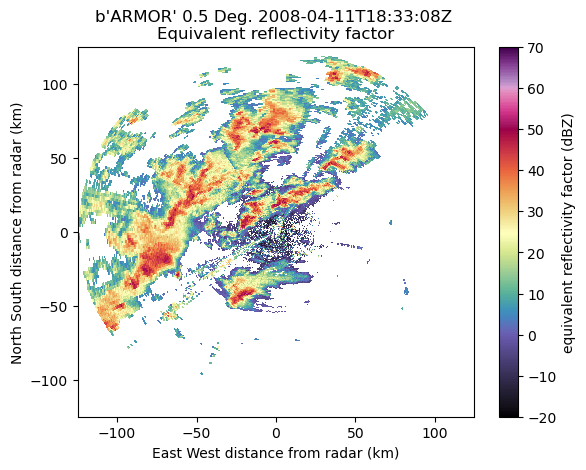

In [24]:
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity',
             vmin=-20,
             vmax=70,
             cmap='pyart_ChaseSpectral',
             sweep=0)

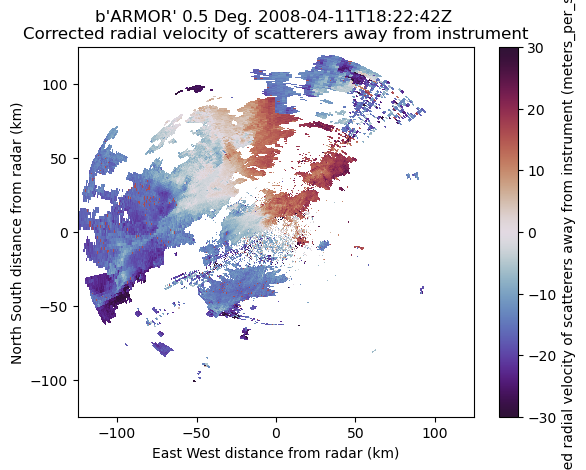

In [5]:
display = pyart.graph.RadarDisplay(radar)
display.plot('corrected_velocity',
             vmin=-30,
             vmax=30,
             cmap='twilight_shifted',
             sweep=0)

In [6]:
grid_limits = ((0., 15000.), (-50_000., 50_000.), (-50_000., 50_000.))
grid_shape = (31, 201, 201)
uah_grid = pyart.map.grid_from_radars([radar], grid_limits=grid_limits,
                                 grid_shape=grid_shape)
uah_ds = uah_grid.to_xarray()
uah_ds

<xarray.Dataset>
Dimensions:                      (time: 1, z: 31, y: 201, x: 201)
Coordinates:
  * time                         (time) object 2008-04-11 18:22:42
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
    lat                          (y, x) float64 34.2 34.2 34.2 ... 35.09 35.09
    lon                          (y, x) float64 -87.32 -87.31 ... -86.23 -86.22
  * y                            (y) float64 -5e+04 -4.95e+04 ... 4.95e+04 5e+04
  * x                            (x) float64 -5e+04 -4.95e+04 ... 4.95e+04 5e+04
Data variables:
    corrected_velocity           (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio      (time, z, y, x) float32 nan nan nan ... nan nan
    velocity                     (time, z, y, x) float32 nan nan nan ... nan nan
    differential_reflectivity    (time, z, y, x) float32 nan nan nan ... nan nan
    spectrum_width               (time, z, y, x) float32 nan nan nan ... nan nan
    differential_phase           (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity                 (time, z, y, x) float32 nan nan nan ... nan nan
    specific_differential_phase  (time, z, y, x) float32 nan nan nan ... nan nan
    total_power                  (time, z, y, x) float32 1.171 1.0 ... nan nan
    ROI                          (time, z, y, x) float32 1.852e+03 ... 2.602e+03

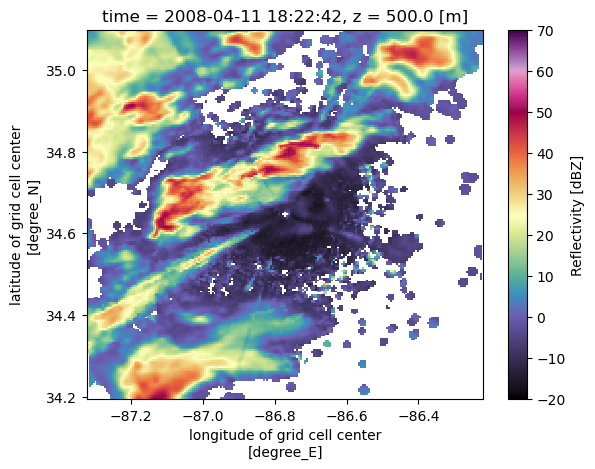

In [7]:
uah_ds.isel(z=1).reflectivity.plot(x='lon',
                                   y='lat',
                                   vmin=-20,
                                   vmax=70,
                                   cmap='pyart_ChaseSpectral')

### NEXRAD Data

In [8]:
fs = fsspec.filesystem("s3", anon=True)

In [9]:
files = sorted(fs.glob("s3://noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_18*"))
files

['noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_180040.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_180647.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_181144.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_181643.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_182140.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_182639.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_183137.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_183635.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_184134.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_184632.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_185130.gz',
 'noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_185628.gz']

Read a single file, the one closes to the UAH volume scan used before

In [10]:
nexrad_radar = pyart.io.read_nexrad_archive(f's3://{files[4]}', station='KHTX')

(-200.0, 200.0)

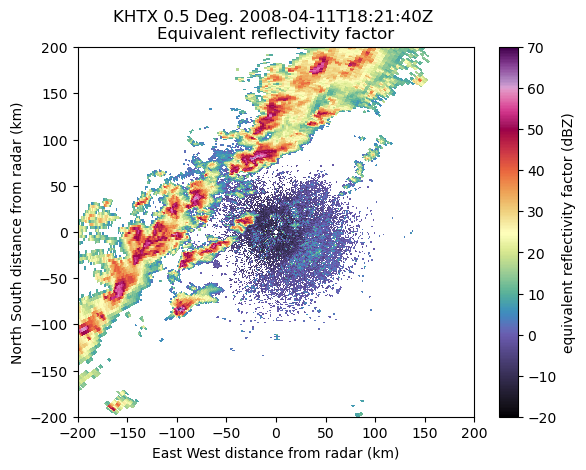

In [11]:
display = pyart.graph.RadarDisplay(nexrad_radar)
display.plot('reflectivity',
                     vmin=-20,
                     vmax=70,
                     cmap='pyart_ChaseSpectral',
                     sweep=0)
plt.ylim(-200, 200)
plt.xlim(-200, 200)

In [12]:
# Use the ARMOR radar lat/lon as the center for the grid
grid_lat = radar.latitude['data'][0]
grid_lon = radar.longitude['data'][0]

# Make sure the velocity is called corrected velocity to match the corrected data from ARMOR
nexrad_radar.add_field_like('velocity',
                            'corrected_velocity',
                            nexrad_radar.fields['velocity']['data'],
                            replace_existing=True)

nexrad_grid = pyart.map.grid_from_radars([nexrad_radar],
                                         grid_limits=grid_limits,
                                         grid_shape=grid_shape,
                                         grid_origin = (grid_lat, grid_lon),
                                        )

# Convert to xarray and remove the time dimension
nexrad_ds = nexrad_grid.to_xarray().squeeze()

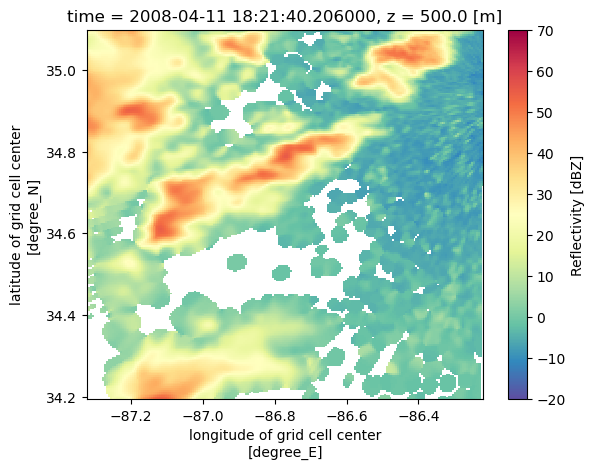

In [13]:
nexrad_ds.reflectivity.isel(z=1).plot(x='lon',
                                      y='lat',
                                      cmap='Spectral_r',
                                      vmin=-20,
                                      vmax=70)

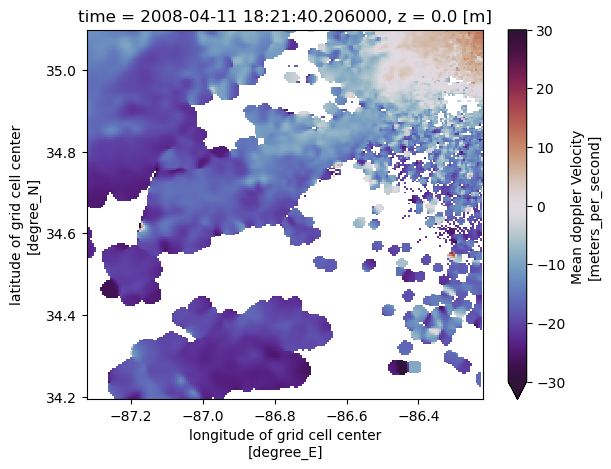

In [14]:
nexrad_ds.velocity.isel(z=0).plot(x='lon',
                                  y='lat',
                                  cmap='twilight_shifted',
                                  vmin=-30,
                                  vmax=30)

In [16]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(
    uah_grid, (0.0, 0.0, 0.0), vel_field='corrected_velocity')

In [18]:
grids = pydda.retrieval.get_dd_wind_field([uah_grid, nexrad_grid], u_init,
                                          v_init, w_init, Co=1.0, Cm=256.0,
                                          Cx=1e-3, Cy=1e-3, Cz=1e-3, Cb=0.,
                                          frz=5000.0, filter_window=5,
                                          mask_outside_opt=True, upper_bc=1,
                                          vel_name='corrected_velocity',
                                          wind_tol=0.5, engine="tensorflow")

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 18.322123
Total points: 367709
The max of w_init is 0.0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|370967.1250|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 1.461657
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10| 176.7620| 849.4446|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  14.2568
The gradient of the cost functions is 0.47561827
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|  12.5757| 322.8624|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  32.6678
The gradient of the cost functions is 1.5369279
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30|   6.8900| 210.7546|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  41.8288


In [19]:
ds = grids[1].to_xarray()

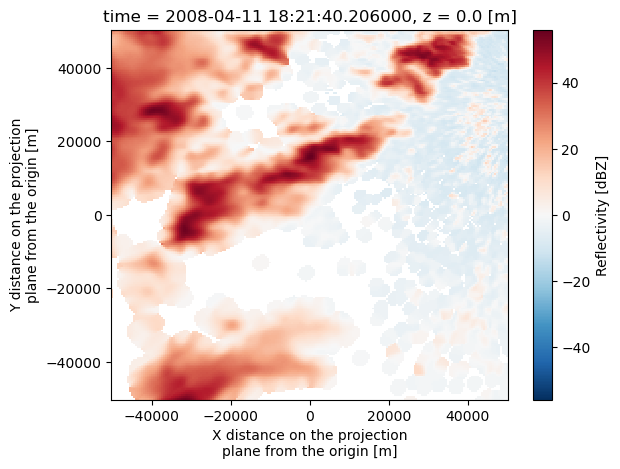

In [20]:
ds.reflectivity.isel(z=0, time=0).plot()

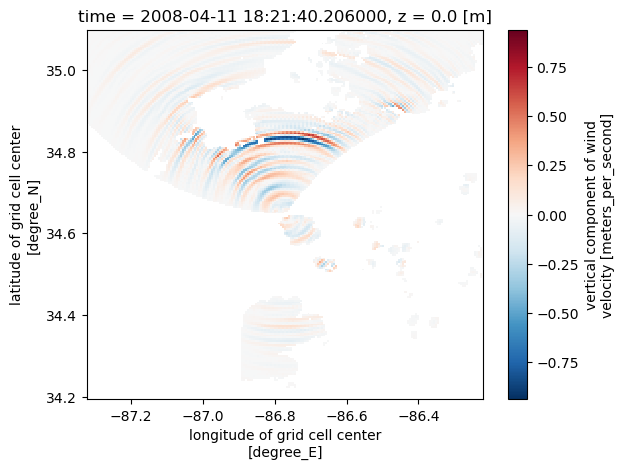

In [21]:
ds.w.isel(z=0, time=0,).plot( x='lon', y='lat')